In [48]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [49]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe
import julian
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

In [50]:
#Bounding Box for Philippines
lonmin = 117.17427453
latmin = 5.58100332277
lonmax = 126.537423944
latmax = 18.5052273625

# Merge and load swaths:

In [51]:
def preprocess(ds):
    dsnew = ds.drop_dims('iT')
    return dsnew

direc = '/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_SWATHS/'

# Open series of files
ds0 = xr.open_mfdataset(direc+'WPC_000/wspd_phi_swaths_000_*.nc',combine='by_coords',preprocess=preprocess,parallel=True)
ds1 = xr.open_mfdataset(direc+'WPC_001/wspd_phi_swaths_001_*.nc',combine='by_coords',preprocess=preprocess,parallel=True)
ds2 = xr.open_mfdataset(direc+'WPC_002/wspd_phi_swaths_002_*.nc',combine='by_coords',preprocess=preprocess,parallel=True)

# Adjust nS coordinate so can concatenate
ds1b = ds1.assign_coords(nS = ds1.nS + ds0.nS.max() + 1)
ds2b = ds2.assign_coords(nS = ds2.nS + ds1b.nS.max() + 1)

ds_merged = xr.concat([ds0,ds1b,ds2b],dim='nS')

swath = ds_merged.swath


# Get data for exposure and vulnerability ready and regrid swaths to match.

In [52]:
# Exposed Value Data, subset over Philippines
ds_exp = xr.open_dataset('EXPOSED_VALUE/LitPopExposure_World.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
exposed_value = ds_exp.data
#ds_exp = xr.open_dataset('EXPOSED_VALUE/asia_exposed_value_reduced.nc').sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
#exposed_value = ds_exp.exposed_value


# Determine Regridder for Hazard --> Exposed Value
regridder = xe.Regridder(swath, ds_exp, 'bilinear',reuse_weights=True)


# Load Philippines province masks

d_mask = xr.open_dataset('/home/jbaldwin/WorldBank/Region_Masks/philippines_province_masks.nc').rename(longitude='lon',latitude='lat')
pickle_in = open("/home/jbaldwin/WorldBank/Region_Masks/state_ids.p","rb")
state_ids = pickle.load(pickle_in)

# Load Vhalf values from household survey data

pickle_in = open("/home/jbaldwin/WorldBank/HOUSEHOLD_SURVEY_DATA/Vhalf_est.p","rb")
Vhalf_est = pickle.load(pickle_in)

# Making region names consistent between state_ids and Vhalf_est dicts

Vhalf_est['Ilocos Region'] = Vhalf_est.pop('I - Ilocos') 
Vhalf_est['Cagayan Valley'] = Vhalf_est.pop('II - Cagayan Valley') 
Vhalf_est['Central Luzon'] = Vhalf_est.pop('III - Central Luzon') 
Vhalf_est['Calabarzon'] = Vhalf_est.pop('IVA - CALABARZON') 
Vhalf_est['Mimaropa'] = Vhalf_est.pop('IVB - MIMAROPA') 
Vhalf_est['Zamboanga Peninsula'] = Vhalf_est.pop('IX - Zamboanga Peninsula') 
Vhalf_est['Bicol Region'] = Vhalf_est.pop('V - Bicol') 
Vhalf_est['Western Visayas'] = Vhalf_est.pop('VI - Western Visayas') 
Vhalf_est['Central Visayas'] = Vhalf_est.pop('VII - Central Visayas') 
Vhalf_est['Eastern Visayas'] = Vhalf_est.pop('VIII - Eastern Visayas') 
Vhalf_est['Northern Mindanao'] = Vhalf_est.pop('X - Northern Mindanao') 
Vhalf_est['Davao Region'] = Vhalf_est.pop('XI - Davao') 
Vhalf_est['Soccsksargen'] = Vhalf_est.pop('XII - SOCCSKSARGEN') 
Vhalf_est['Caraga'] = Vhalf_est.pop('XIII - Caraga')

# Create list of state names
regions = state_ids.keys()


# Assign vulnerability on map to different provinces
Vhalf_map = xr.open_dataset('Vhalf_map.nc').rename(longitude='lon',latitude='lat')

# Vhalf_map = xr.Dataset.copy(d_mask)
# for key in regions:
#     Vhalf_map.states.values[Vhalf_map.states==state_ids[key]] = Vhalf_est[key]
    

# Regrid wind swath
swath_out = regridder(swath)


Reuse existing file: bilinear_146x111_1551x1124.nc


In [86]:
Vhalf_map

<xarray.Dataset>
Dimensions:  (lat: 1551, lon: 1124)
Coordinates:
  * lon      (lon) float32 117.179 117.187 117.195 ... 126.52 126.529 126.537
  * lat      (lat) float32 5.587 5.595 5.604 5.612 ... 18.487 18.495 18.504
Data variables:
    states   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [53]:
# function for Emanuel Vulnerability Curves

def vulnerability(V,Vthresh,Vhalf): # calculate fractional property value lost over space

    # V = Input wind speed swath; m/s
    
    # Vthresh = windspeed at and below which no damage occurs; m/s

    # Vhalf = windspeed at which half the property value is lost; m/s

    vn0 = V-Vthresh
    vn = xr.ufuncs.maximum(vn0, vn0*0)/(Vhalf-Vthresh) # ufuncs so can take advantage of dask speedups
    f = vn**3/(1+vn**3)
    
    return f # vulnerability in all different regions

# Calculate Asset Losses for Each Historical Storm

In [54]:
# Calculate vulnerability

Vthresh = 25.7# Eberenz et al 2020, value for Philippines; m/s
Vhalf = Vhalf_map.states#84.7# Eberenz et al 2020, value for Philippines using RMSF calculation; m/s
V = swath_out

f = vulnerability(V,Vthresh,Vhalf)


In [55]:
# Calculate asset losses

asset_losses = exposed_value*f

# Calculate number of storms reaching tropical storm strength in each region over period.

In [56]:
# REGION TO DO THE HEAVY COMPUTATION AND PLOTTING OVER

focus_region = 'Eastern Visayas'
focus_region_nospace = 'EasternVisayas'

In [57]:
# Calculate max wind, and number of tropical storms, and their frequency, in each region
ts_count = {}
ts_per_year = {}
max_wind = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask = mask0/mask0
    max_wind[key] = (swath_out*mask).max(dim='lon',skipna = True).max(dim='lat', skipna = True) # calculate max across region
    ts_count[key] = (max_wind[key]>(40/1.944)).sum(dim='nS').sum(dim='ensembleNum') # count storms above tropical storm threshold


In [58]:
# Load historical data of ts_per_year

pickle_in = open("ts_per_year.p","rb")
ts_per_year = pickle.load(pickle_in)

In [59]:
# Determine period that is consistent with historical

period_years = {}
for reg in [focus_region]:
    period_years[reg] = ts_count[reg]/ts_per_year[reg]

In [60]:
#%%time

# NOTE: THIS STEP TAKES A LONG TIME!
# Get values for data
obsw = np.concatenate(max_wind[focus_region])
obsy = float(period_years[focus_region])

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


CPU times: user 10.2 s, sys: 15.2 s, total: 25.4 s
Wall time: 5.07 s


In [61]:
# Save out data for max wind and period

direc_save = '/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_REGION/'

ds_max_wind = xr.DataArray.to_dataset(max_wind[focus_region],name='max_wind')

ds_max_wind.attrs["period_years"] = obsy

ds_max_wind.to_netcdf(direc_save+'wpc0-2_maxwind_'+focus_region_nospace+'.nc')

Text(0.5, 1.0, 'Eastern Visayas')

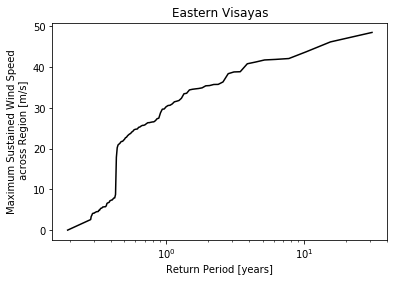

In [62]:
# Calculate return periods for different exceedance levels
ax1 = plt.subplot(111)
pdfevents,bins = np.histogram(obsw,np.unique(np.hstack([np.sort(obsw),obsw.max()+5]))) # determine frequency in each bin
cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
returnP_o = 1./cdfevents # calculate return period (1/f)
dot, = ax1.semilogx(returnP_o[:],bins[:-1],'k-',label='obs',zorder=20)
plt.xlabel('Return Period [years]')
plt.ylabel('Maximum Sustained Wind Speed\n across Region [m/s]')
plt.title(focus_region)

In [63]:
# Find exceedance values for different prescribed return periods
r = np.array([1.,5.,10.,20.,50.,100.,200.,500.])
e_max_wind = {}
for i in range(len(r)):
    index_of_returnperiod = np.argmin(np.abs(returnP_o-r[i]))
    e_max_wind[r[i]] = bins[index_of_returnperiod]
    
# Save out exceedance for return periods    
pickle.dump( e_max_wind, open( direc_save + 'e_max_wind_'+focus_region_nospace+'.p', "wb" ) )

# Calculate regional asset losses.

In [64]:
# Calculate asset losses summed over region

asset_losses_reg = {}
for key in regions:
    mask0 = d_mask.states.where(d_mask.states==state_ids[key])
    mask = mask0/mask0
    asset_losses_reg[key] = (asset_losses*mask).sum(dim='lon',skipna = True).sum(dim='lat', skipna = True) # mask and calculate sum across region


In [65]:
#%%time

# NOTE: THIS STEP TAKES A LONG TIME!
# Get values for data
obsa = np.concatenate(asset_losses_reg[focus_region])
# obsy defined earlier

CPU times: user 12.2 s, sys: 13.1 s, total: 25.3 s
Wall time: 14.1 s


In [69]:
# Save out data for asset_losses and period

ds_asset_losses = xr.DataArray.to_dataset(asset_losses_reg[focus_region],name='asset_losses')

ds_asset_losses.attrs["period_years"] = obsy

ds_asset_losses.to_netcdf('/data2/jbaldwin/WINDFIELDS/ERAInterim_WPC/PHI_REGION/wpc0-2_assetlosses_'+focus_region_nospace+'.nc')

Text(0.5, 1.0, 'Eastern Visayas')

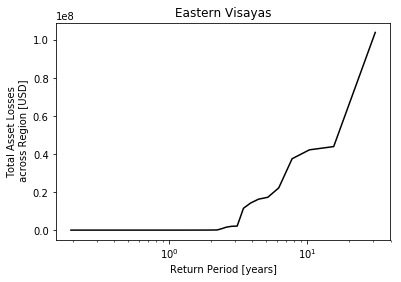

In [70]:
# Calculate return periods for different exceedance levels
ax1 = plt.subplot(111)
pdfevents,bins = np.histogram(obsa,np.unique(np.hstack([np.sort(obsa),obsa.max()+5]))) # determine frequency in each bin
cdfevents = 1.*np.cumsum(pdfevents[::-1])[::-1]/obsy # calculate cumulative frequency per year in each bin
returnP_o = 1./cdfevents # calculate return period (1/f)
dot, = ax1.semilogx(returnP_o[:],bins[:-1],'k-',label='obs',zorder=20)
plt.xlabel('Return Period [years]')
plt.ylabel('Total Asset Losses\n across Region [USD]')
plt.title(focus_region)

In [71]:
# Find exceedance values for different prescribed return periods
r = np.array([1.,5.,10.,20.,50.,100.,200.,500.])
e_asset_losses = {}
for i in range(len(r)):
    index_of_returnperiod = np.argmin(np.abs(returnP_o-r[i]))
    e_asset_losses[r[i]] = bins[index_of_returnperiod]
    
# Save out exceedance for return periods    
pickle.dump( e_asset_losses, open( direc_save + 'e_asset_losses_'+focus_region_nospace+'.p', "wb" ) )